In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/content/6_cleaned_data_v2.csv")

In [4]:
df_encoded = df.copy()

In [5]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")

City: ['INDO' 'BANG' 'COIMB' 'CHEN' 'HYD' 'RANCHI' 'MYS' 'DEH' 'KOC' 'PUNE'
 'LUDH' 'KNP' 'MUM' 'KOL' 'JAP' 'SUR' 'GOA' 'AURG' 'AGR' 'VAD' 'ALH' 'BHP']
Weatherconditions: ['Sunny' 'Stormy' 'Sandstorms' 'Cloudy' 'Fog' 'Windy']
traffic_type: ['high' 'jam' 'low' 'medium']
Type_of_order: ['Snack ' 'Drinks ' 'Buffet ' 'Meal ']
Type_of_vehicle: ['motorcycle' 'scooter' 'electric_scooter' 'bicycle']
Festival: ['no' 'yes']
City_type: ['urban' 'metropolitian' 'semi-urban']
weekday: ['Saturday' 'Friday' 'Tuesday' 'Monday' 'Sunday' 'Wednesday' 'Thursday']
order_time_of_day: ['Morning' 'Evening' 'Afternoon']


In [6]:
from sklearn.preprocessing import LabelEncoder
cols = df.select_dtypes(include='object').columns.to_list()
le = LabelEncoder()
for col in cols:
    df_encoded[col] = le.fit_transform(df[col])


In [7]:
X = df_encoded.drop('time_taken', axis=1)
y = df_encoded['time_taken']

## 1. correlation analysis

<Axes: >

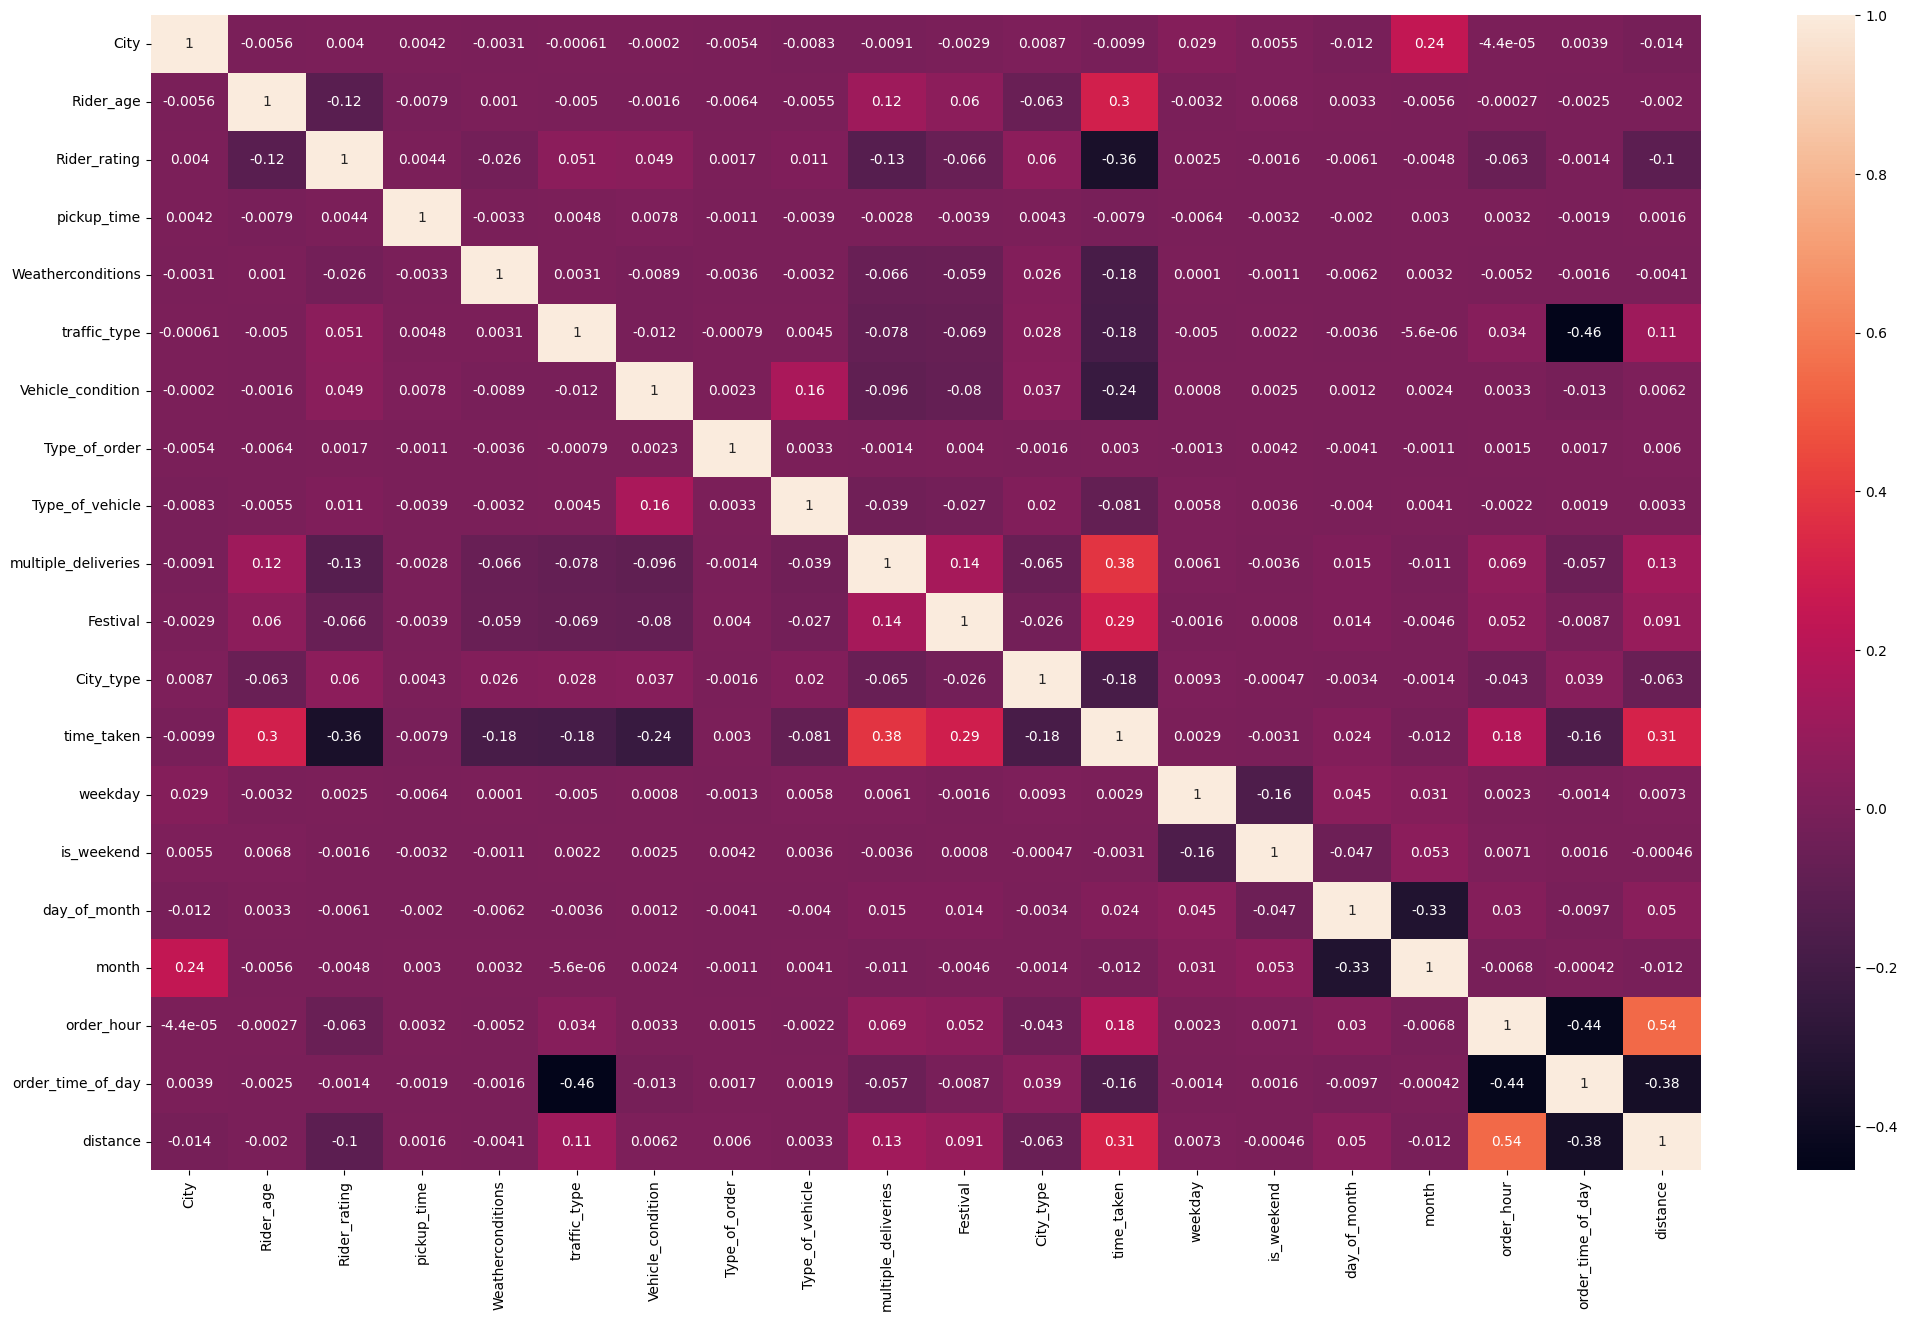

In [8]:
plt.figure(figsize=(25,15))
sns.heatmap(df_encoded.corr(), annot=True)

In [9]:
fi_1 = df_encoded.corr()['time_taken'].to_frame().reset_index().rename(columns={'index':'feature','time_taken':'corr_coeff'}).drop(12)
fi_1['corr_coeff'] = np.abs(fi_1['corr_coeff'] / np.sum(np.abs(fi_1['corr_coeff'])))
fi_1.sort_values(by='corr_coeff', ascending=False, inplace=True)
fi_1

,feature,corr_coeff
9,multiple_deliveries,0.132049
2,Rider_rating,0.122538
19,distance,0.107602
1,Rider_age,0.102258
10,Festival,0.099839
6,Vehicle_condition,0.080984
5,traffic_type,0.063383
17,order_hour,0.063010
4,Weatherconditions,0.062677
11,City_type,0.061338


## 2.Random Forest Feature Imp

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)


fi_2 = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_2

,feature,rf_importance
2,Rider_rating,0.206763
4,Weatherconditions,0.134596
18,distance,0.121668
9,multiple_deliveries,0.119231
5,traffic_type,0.109820
1,Rider_age,0.081062
6,Vehicle_condition,0.069817
16,order_hour,0.055653
0,City,0.022304
14,day_of_month,0.019444


## 3.Gradient Boosting Feature importances

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X, y)

fi_3 = pd.DataFrame({
    'feature': X.columns,
    'gb_importance': gb.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_3

,feature,gb_importance
2,Rider_rating,0.224141
4,Weatherconditions,0.146806
5,traffic_type,0.144395
9,multiple_deliveries,0.112226
18,distance,0.105859
1,Rider_age,0.098009
6,Vehicle_condition,0.087139
16,order_hour,0.044440
10,Festival,0.025933
11,City_type,0.010770


## 4.Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)

In [19]:
fi_4 = pd.DataFrame({
    'feature': X.columns,
    'permutation_importance': abs(perm_importance.importances_mean)
}).sort_values(by='permutation_importance', ascending=False)

fi_4

,feature,permutation_importance
4,Weatherconditions,0.379407
5,traffic_type,0.295403
1,Rider_age,0.234073
2,Rider_rating,0.226670
6,Vehicle_condition,0.209585
18,distance,0.192736
9,multiple_deliveries,0.151226
16,order_hour,0.075516
10,Festival,0.008062
17,order_time_of_day,0.005295


## 5.LASSO

In [13]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y)

Lasso(alpha=0.01, random_state=42)

In [14]:
lasso.coef_ = np.abs(lasso.coef_ / np.sum(np.abs(lasso.coef_)))

fi_5 = pd.DataFrame({
    'feature': X.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_5

,feature,lasso_coeff
5,traffic_type,0.123527
2,Rider_rating,0.119401
1,Rider_age,0.108571
18,distance,0.108535
9,multiple_deliveries,0.100806
17,order_time_of_day,0.097284
6,Vehicle_condition,0.090801
10,Festival,0.079380
4,Weatherconditions,0.078225
11,City_type,0.044284


## 6.RFE

In [16]:
from sklearn.feature_selection import RFE

estimator = RandomForestRegressor()

selector = RFE(estimator, n_features_to_select=X.shape[1], step=1)
selector = selector.fit(X, y)

selected_features = X.columns[selector.support_]

selected_coefficients = selector.estimator_.feature_importances_

fi_6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_6

,feature,rfe_score
2,Rider_rating,0.206042
4,Weatherconditions,0.134988
18,distance,0.121028
9,multiple_deliveries,0.119569
5,traffic_type,0.109003
1,Rider_age,0.081441
6,Vehicle_condition,0.069534
16,order_hour,0.056867
0,City,0.022384
14,day_of_month,0.019567


## 7.Linear Regression Weights

In [17]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y)

lin_reg.coef_ = np.abs(lin_reg.coef_ / np.sum(np.abs(lin_reg.coef_)))

fi_7 = pd.DataFrame({
    'feature': X.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_7

,feature,reg_coeffs
5,traffic_type,0.123371
2,Rider_rating,0.118524
18,distance,0.108295
1,Rider_age,0.107860
9,multiple_deliveries,0.099852
17,order_time_of_day,0.097656
6,Vehicle_condition,0.090278
10,Festival,0.078833
4,Weatherconditions,0.077911
11,City_type,0.044169


## Overall Feature Importance

In [20]:
fi = fi_1.merge(fi_2, on='feature').merge(fi_3, on='feature').merge(fi_4, on='feature').merge(fi_5, on='feature').merge(fi_6, on='feature').merge(fi_7, on='feature').set_index('feature')
fi = fi.divide(fi.sum(axis=0), axis=1)
fi

,corr_coeff,rf_importance,gb_importance,permutation_importance,lasso_coeff,rfe_score,reg_coeffs
feature,,,,,,,
multiple_deliveries,0.132049,0.119231,0.112226,0.084735,0.100806,0.119569,0.099852
Rider_rating,0.122538,0.206763,0.224141,0.127009,0.119401,0.206042,0.118524
distance,0.107602,0.121668,0.105859,0.107994,0.108535,0.121028,0.108295
Rider_age,0.102258,0.081062,0.098009,0.131157,0.108571,0.081441,0.107860
Festival,0.099839,0.009622,0.025933,0.004517,0.079380,0.009724,0.078833
Vehicle_condition,0.080984,0.069817,0.087139,0.117436,0.090801,0.069534,0.090278
traffic_type,0.063383,0.109820,0.144395,0.165521,0.123527,0.109003,0.123371
order_hour,0.063010,0.055653,0.044440,0.042314,0.029017,0.056867,0.030327
Weatherconditions,0.062677,0.134596,0.146806,0.212591,0.078225,0.134988,0.077911


In [21]:
fi.columns

Index(['corr_coeff', 'rf_importance', 'gb_importance',
       'permutation_importance', 'lasso_coeff', 'rfe_score', 'reg_coeffs'],
      dtype='object')

In [25]:
fi = fi[['corr_coeff', 'rf_importance', 'gb_importance',
       'permutation_importance', 'lasso_coeff', 'rfe_score', 'reg_coeffs']].mean(axis=1).sort_values(ascending=False).reset_index().rename(columns={0:'mean_importance'})

In [26]:
fi

,feature,mean_importance
0,Rider_rating,0.160631
1,Weatherconditions,0.121113
2,traffic_type,0.119860
3,distance,0.111569
4,multiple_deliveries,0.109781
5,Rider_age,0.101480
6,Vehicle_condition,0.086570
7,order_hour,0.045947
8,Festival,0.043978
9,order_time_of_day,0.037043


- **we can see that features from `type_of_vehicle` to `is_weekend` are having feature importance less than 0.01 but we need to cross validate using model**

In [30]:
low_fi = fi[fi['mean_importance']<0.01]['feature'].to_list()

In [23]:
# with all Columns
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
scores.mean()

np.float64(0.8007977136655322)

In [32]:
# without columns having feature imp < 0.01
rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X.drop(columns=low_fi), y, cv=5, scoring='r2')
scores.mean()

np.float64(0.7932870252581677)

- **we can see that these features doesn't affect much to r2 score so we will drop these features**

In [33]:
df.drop(columns=low_fi, inplace=True)

In [34]:
df.to_csv("final_data.csv",index=False)